<a href="https://colab.research.google.com/github/abasit/facial-detection-debiasing/blob/master/Hyperconnectivity_Paradox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Hyperconnectivity Paradox in Neuroscience

## The Problem
Neuroscience research in early-stage dementia demonstrates a curious phenomenon: patients show increased brain connectivity (under various mathematical measures) while simultaneously exhibiting decreased cognitive function. This hyperconnectivity paradox appears across multiple studies, measurement techniques, and neurodegenerative diseases.

Current neuroscience research formalises brain connectivity using the mathematical framework of graphs, which capture pairwise connectivity. Arguably, such an approach is missing crucial information about **higher-order coordination processes**. Here, we investigate a hypergraph-based framework, which can potentially help us understand the hyperconnectivity paradox better.

We start by installing and importing required packages.

In [1181]:
# Install required packages
!pip install hypernetx &> /dev/null

# Core imports
import math
import numpy as np
import networkx as nx
import hypernetx as hnx
import matplotlib.pyplot as plt
from itertools import combinations

## The Approach

To test the framework, we'll generate synthetic neural time series data for **healthy brains** and **dementia brains**. We then compare how graphs and hypergraphs capture the resulting connectivity patterns.

The parameters below are chosen to keep the demonstration clear and interpretable while still capturing the essential mathematical phenomena.

---

In [1182]:
# Fixed seed for reproducibility
seed = 42

# Data generation parameters
n_regions = 10              # Number of brain regions to simulate
n_timepoints = 1000         # Length of neural time series
n_coords = {                # Coordination blocks to generate
    2: 3,  # Three 2-region coordination pairs
    3: 2,  # Two 3-region hub-spoke structures
    4: 1   # One 4-region complex coordination patterns
}

# Hypergraph detection parameters
tau = 0.7        # Minimum correlation for "strong" pairwise connections
epsilon = 0.35    # Maximum correlation for "weak" conditional connections (mediation)
max_k = 4        # Largest hyperedge size to detect

# 2. Data Generation: Simulating Brain Coordination Patterns

## Coordination Blocks

We begin by generating the **coordination blocks**, which are the groups of brain regions that will coordinate together in our synthetic data. Each coordination block represents a functional unit where multiple regions work together to support cognitive processes.


In [1183]:
# Generate coordination blocks randomly, making sure there's no duplicates
rng = np.random.default_rng(seed=seed)

coordination_blocks = []
for block_size, num_blocks in n_coords.items():
    for _ in range(num_blocks):
        # Randomly select regions for this coordination block
        while True:
            block_regions = sorted(rng.choice(range(n_regions), size=block_size, replace=False))
            if block_regions not in coordination_blocks:
                coordination_blocks.append([int(region) for region in block_regions])
                break

print("Generated coordination blocks:")
for block in coordination_blocks:
    print(block)

Generated coordination blocks:
[0, 7]
[3, 4]
[0, 6]
[0, 4, 9]
[5, 7, 9]
[1, 3, 4, 8]


Given the coordination blocks, we can already start comparing the two frameworks. The graph-based approach is only able to capture higher-order blocks via their pairwise components. For example, the block [0, 4, 9] results in the pairwise connections [0,4], [0, 9] and [4, 9]. On the other hand, a hypergraph lets us capture the group structure as is.

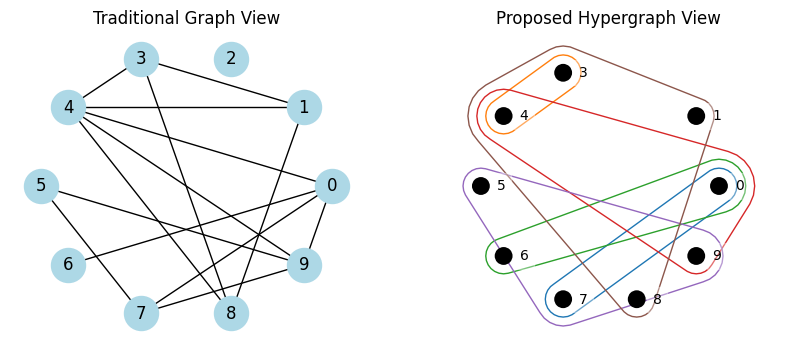

In [1184]:
# Construct graph to capture pairwise coordination
edges = []
for block in coordination_blocks:
  edges.extend(combinations(block, 2))
graph = nx.Graph()
graph.add_nodes_from(range(n_regions))
graph.add_edges_from(edges)

# Construct hypergraph to capture multi-region coordination
hyperedges = {}
for i, block in enumerate(coordination_blocks):
    hyperedges[i] = block
hypergraph = hnx.Hypergraph(hyperedges)
hypergraph.add_nodes_from(range(n_regions))

# Visualize side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

pos = nx.circular_layout(range(n_regions))

# Graph view on left
nx.draw(graph, ax=ax1, pos=pos, with_labels=True, node_color='lightblue', node_size=600)
ax1.set_title('Traditional Graph View')

# Hypergraph view (right)
hnx.draw(hypergraph, ax=ax2, pos=pos, with_edge_labels=False, node_radius=3)
ax2.set_title('Proposed Hypergraph View')

plt.show()

## 2.2 Generating timeseries data

### Timeseries data for a healthy brain

The healthy brain data consists of three main components:

**1. Background noise:** Each region starts with independent random noise.

**2. Individual oscillations:** Each region gets its own unique oscillatory pattern (different frequencies and phases).

**3. Hub-spoke coordination:** We break up the timeseries into windows where each time window represents a period where the subject is performing a particular task and only a specific block is active.
Within each block, the first region acts as a **coordination hub** that receives a strong task-related signal. The remaining **spoke regions** receive this hub signal plus independent noise.

This creates the mathematical signatures the hypergraph framework is designed to detect: strong pairwise correlations that become weak when controlling for mediating regions.

In [1185]:
def generate_healthy_brain(coordination_blocks, n_regions, n_timepoints):
    '''
    Args:
        coordination_blocks (list): List of coordination blocks
        n_regions (int): Total number of brain regions to simulate
        n_timepoints (int): Length of the generated time series

    Returns:
        np.ndarray: Neural time series data of shape (n_regions, n_timepoints)
    '''
    # Fixed seed for reproducibility
    rng = np.random.default_rng(seed=seed)

    # Step 1: Initialize background noise for each region
    data = rng.normal(0, 0.1, (n_regions, n_timepoints))

    # Step 2: Add individual baseline oscillations to all regions
    for region in range(n_regions):
        # Individual oscillation frequency -- Between 40 and 120 periods for each
        # 1000 timesteps (arbitrary choice)
        freq = rng.uniform(0.04, 0.12)
        phase = rng.uniform(0, 2 * np.pi)
        baseline_strength = rng.uniform(0.1, 0.2) # Baseline activity on the lower end

        baseline_signal = baseline_strength * np.sin(freq * np.arange(n_timepoints) + phase)
        data[region] += baseline_signal

    # Step 3: Generate hub-spoke coordination patterns
    segment_size = n_timepoints // len(coordination_blocks)
    for block_idx, block_regions in enumerate(coordination_blocks):
        # Each block gets its own time window
        start_time = block_idx * segment_size
        end_time = start_time + segment_size
        if block_idx == len(coordination_blocks) - 1:  # Last block gets remaining time
            end_time = n_timepoints

        time_segment = np.arange(start_time, end_time)

        # Hub-spoke structure
        hub_region = block_regions[0]      # First region is the coordination hub
        spoke_regions = block_regions[1:]  # Remaining regions are the spokes

        # Generate coordination signal for this time window
        coord_freq = rng.uniform(0.07, 0.14) # Coordination signals are higher frequency
        coord_phase = rng.uniform(0, 2 * np.pi)
        coord_signal = np.sin(coord_freq * time_segment + coord_phase)

        # Hub receives strong, clean coordination signal
        data[hub_region][time_segment] += 0.8 * coord_signal

        # Spokes receive hub signal + independent noise
        for spoke in spoke_regions:
            data[spoke][time_segment] += 0.75 * coord_signal
            data[spoke][time_segment] += 0.2 * rng.normal(0, 1, len(time_segment))

    return data

### Timeseries data for a dementia brain

Ths builds on the healthy brain with some important changes:

**1. Reduced baseline activity:** All signals are weakened, simulating the decreased neural efficiency.

**2. Global interference noise:** A shared "noise" signal is added across all regions with varying strengths. This creates **spurious pairwise correlations** between regions that might not be otherwise connected.

**3. Individual noise:** Random noise is injected into the signal of each region, destroying higher-order connectivity.

This is designed to emulate the **hyperconnectivity paradox**: the global noise increases overall pairwise connectivity (ρ₂ increases) while interfering with the clean mediation relationships that hypergraphs detect (ρₖ≥₃ decrease).

In [1186]:
def generate_dementia_brain(healthy_data):
    '''
    Args:
        healthy_data (np.ndarray): Healthy brain data of shape (n_regions, n_timepoints)

    Returns:
        np.ndarray: Neural time series data of shape (n_regions, n_timepoints)
    '''
    rng = np.random.default_rng(seed=seed)
    dementia_data = healthy_data.copy()

    # Step 1: Reduce baseline activity
    dementia_data *= 0.7

    # Step 2: Add global noise (creates spurious pairwise correlations)
    global_freq = rng.uniform(0.08, 0.12)
    global_signal = np.sin(global_freq * np.arange(healthy_data.shape[1]))
    global_strengths = rng.uniform(0.1, 0.2, healthy_data.shape[0])

    for region in range(healthy_data.shape[0]):
        dementia_data[region] += global_strengths[region] * global_signal

    # Step 3: Add variable noise (destroys higher-order connectivity)
    for region in range(healthy_data.shape[0]):
        noise_level = rng.uniform(0.05, 0.1)
        dementia_data[region] += noise_level * rng.normal(0, 1, healthy_data.shape[1])

    return dementia_data

We can now generate the synthetic brain timeseries and visualise the data. For ease of visualisation, we only plot signals for a few regions.

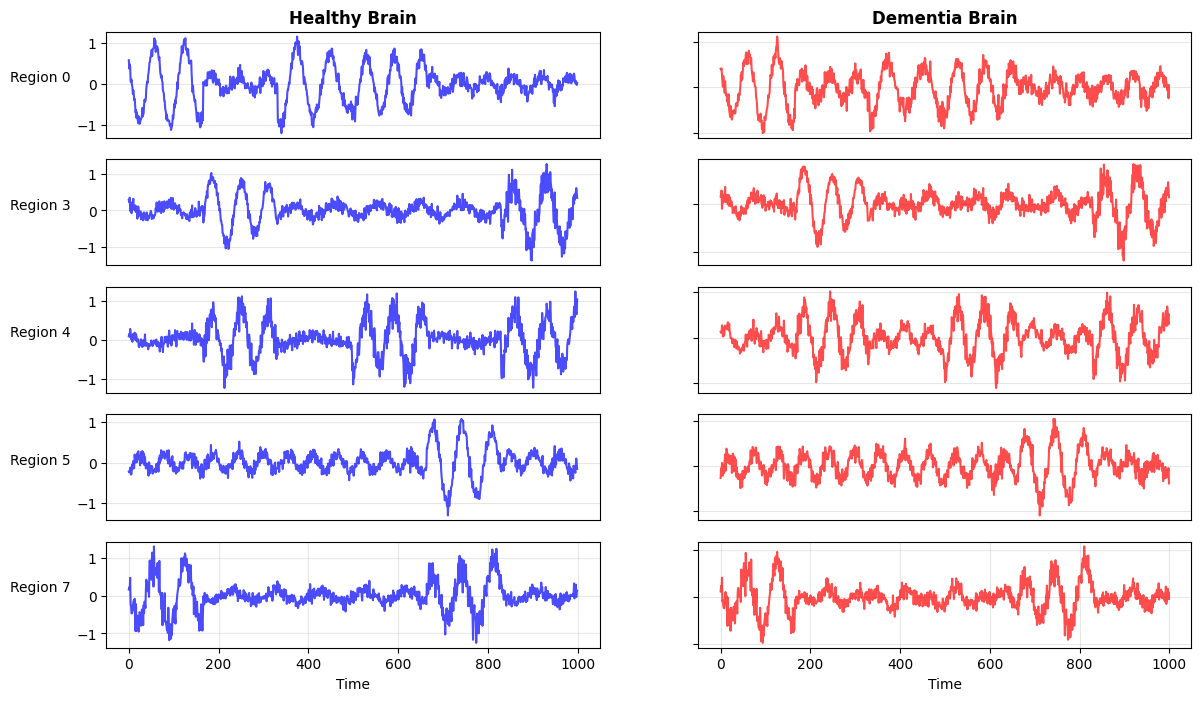

In [1187]:
# Generate healthy and dementia datasets
healthy_data = generate_healthy_brain(coordination_blocks, n_regions, n_timepoints)
dementia_data = generate_dementia_brain(healthy_data)


# Randomly select 5 regions to show
rng = np.random.default_rng(seed=seed)  # Fixed seed for consistency
selected_regions = sorted(rng.choice(n_regions, size=5, replace=False))

fig, axes = plt.subplots(len(selected_regions), 2, figsize=(14, 8))

for i, region in enumerate(selected_regions):
    # Healthy (left)
    axes[i, 0].plot(healthy_data[region], 'b-', alpha=0.7)
    axes[i, 0].set_ylabel(f'Region {region}', rotation=0, ha='right')
    axes[i, 0].grid(True, alpha=0.3)

    # Dementia (right)
    axes[i, 1].plot(dementia_data[region], 'r-', alpha=0.7)
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_yticklabels([])

    # Titles only on first row
    if i == 0:
        axes[i, 0].set_title('Healthy Brain', fontweight='bold')
        axes[i, 1].set_title('Dementia Brain', fontweight='bold')

    # X-labels only on bottom row
    if i == len(selected_regions) - 1:
        axes[i, 0].set_xlabel('Time')
        axes[i, 1].set_xlabel('Time')
    else:
        axes[i, 0].set_xticks([])
        axes[i, 1].set_xticks([])

plt.show()

# 2. Analysing the data

## Graph based analysis

We'll start by analysing the data using the standard graph-based framework, showing the hyperconnectivity paradox in action. We first set up some helper functions.

In [1188]:
def compute_conditional_correlation(data, i, j, k):
    """
    Compute conditional correlation R_{ij|k} using single conditioning variable.
    Uses the standard partial correlation formula for a single conditioning variable.

    Args:
        data (np.ndarray): Neural data of shape (regions, timepoints)
        i (int): Index of first region
        j (int): Index of second region
        k (int): Index of conditioning region

    Returns:
        float: Conditional correlation coefficient between -1 and 1
    """
    corr_matrix = np.corrcoef(data[[i, j, k], :])
    R_ij = corr_matrix[0, 1]
    R_ik = corr_matrix[0, 2]
    R_jk = corr_matrix[1, 2]

    numerator = R_ij - R_ik * R_jk

    denominator = np.sqrt((1 - R_ik ** 2) * (1 - R_jk ** 2))
    if abs(denominator) < 1e-10: return 0.0

    return numerator / denominator

def detect_edges(data, tau, num_blocks):
    """
    Detect pairwise edges using correlation analysis.

    Args:
        data (np.ndarray): Neural data of shape (regions, timepoints)
        tau (float): Correlation threshold for edge detection
        num_blocks (int): Number of time windows to analyze

    Returns:
        list: List of tuples representing detected edges, e.g., [(0,1), (2,3)]
    """
    # We assume each of the blocks is active during a specific time window
    # and that all windows are the same size

    # Compute window size.
    window_size = data.shape[1] // num_blocks
    all_edges = []

    for block_idx in range(num_blocks):
        # Define time window
        start = block_idx * window_size
        end = start + window_size
        if block_idx == num_blocks - 1:  # Last window gets remaining time
            end = data.shape[1]

        # Extract data for this time window and compute correlations
        window_data = data[:, start:end]
        window_corr = np.corrcoef(window_data)

        # Find pairwise edges above threshold
        for i, j in combinations(range(data.shape[0]), 2):
            if abs(window_corr[i, j]) > tau:
                all_edges.append((i, j))

    return list(set(all_edges))

We can now construct the pairwise correlation graphs using the time series data and visualise these graphs.

Note there may be false positives (edges which are not in actual coordination patterns) and false negatives (coordination patterns that go undetected by the algorithm)

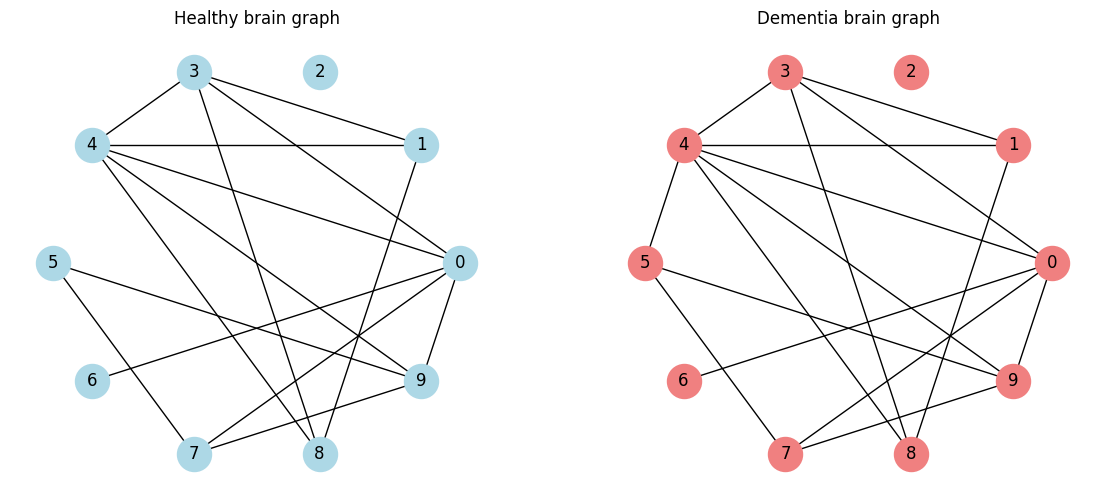


Graph density comparison:
  Healthy: 0.333
  Dementia: 0.356


In [1189]:
# Detect edges in both datasets
healthy_edges = detect_edges(healthy_data, tau, len(coordination_blocks))
dementia_edges = detect_edges(dementia_data, tau, len(coordination_blocks))

# Create NetworkX graphs
healthy_graph = nx.Graph()
healthy_graph.add_nodes_from(range(n_regions))
healthy_graph.add_edges_from(healthy_edges)

dementia_graph = nx.Graph()
dementia_graph.add_nodes_from(range(n_regions))
dementia_graph.add_edges_from(dementia_edges)


# Visualize side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Use same layout for fair comparison
pos = nx.circular_layout(range(n_regions))

# Healthy brain graph
nx.draw(healthy_graph, ax=ax1, pos=pos, with_labels=True, node_color='lightblue', node_size=600)
ax1.set_title(f'Healthy brain graph')

# Dementia brain graph
nx.draw(dementia_graph, ax=ax2, pos=pos, with_labels=True, node_color='lightcoral', node_size=600)
ax2.set_title(f'Dementia brain graph')

plt.show()

# Compute basic graph metrics
print(f"\nGraph density comparison:")
healthy_density = nx.density(healthy_graph)
dementia_density = nx.density(dementia_graph)
print(f"  Healthy: {healthy_density:.3f}")
print(f"  Dementia: {dementia_density:.3f}")

## Hypergraph based analysis

Let's move on to the hypergraph based analysis. We first set up some helper functions implementing the algorithm in the writeup.

Note a minor addition to the algorithm: Once we have detected all the edges, we filter things and keep only the maximal ones. So if an edge is a strict subset of another edge, then we do not consider it. This is purely for visualisation purposes. Without this, the hypergraph has too many edges, and are hard to visualise.

In [1190]:
def compute_conditional_correlation_extended(data, i, j, conditioning_set):
    """
    Compute conditional correlation R_{ij|conditioning_set} using multiple conditioning variables.


    Args:
        data (np.ndarray): Neural data of shape (regions, timepoints)
        i (int): Index of first region
        j (int): Index of second region
        conditioning_set (list): List of region indices to condition on

    Returns:
        float: Conditional correlation coefficient between -1 and 1.
               Returns regular correlation if conditioning_set is empty.
    """
    if len(conditioning_set) == 0:
        return np.corrcoef(data[i, :], data[j, :])[0, 1]

    # Calculate the correlation between regions i and j after removing the linear
    # effects of all regions in the conditioning set. Use regression to compute
    # residuals after controlling for conditioning variables, then correlate the residuals.

    # Step 1: Set up regression matrix
    X_cond = data[conditioning_set, :].T  # (timepoints, conditioning_regions)
    X_cond = np.column_stack([np.ones(data.shape[1]), X_cond])

    # Step 2: Regress i and j on conditioning set
    beta_i = np.linalg.lstsq(X_cond, data[i, :], rcond=None)[0]
    residual_i = data[i, :] - X_cond @ beta_i

    beta_j = np.linalg.lstsq(X_cond, data[j, :], rcond=None)[0]
    residual_j = data[j, :] - X_cond @ beta_j

    # Step 3: Correlate residuals
    return np.corrcoef(residual_i, residual_j)[0, 1]


def detect_hyperedges(data, tau, epsilon, max_k, num_blocks):
    """
    Detect hyperedges implementing the algorithm in the writeup over each time window.

    Args:
        data (np.ndarray): Neural data of shape (regions, timepoints)
        tau (float): Threshold for strong pairwise correlations
        epsilon (float): Threshold for weak conditional correlations
        max_k (int): Maximum hyperedge size to detect
        num_blocks (int): Number of time windows to analyze

    Returns:
        list: list containing tuples for edges of every size
    """
    # We assume each of the blocks is active during a specific time window
    # and that all windows are the same size

    # Compute window size
    window_size = data.shape[1] // num_blocks
    all_edges = []

    for block_idx in range(num_blocks):
        # Define time window
        start = block_idx * window_size
        end = start + window_size
        if block_idx == num_blocks - 1:  # Last window gets remaining time
            end = data.shape[1]

        # Extract window data and compute correlations
        window_data = data[:, start:end]
        window_corr = np.corrcoef(window_data)

        # Step 1: Detect pairwise edges (k=2)
        for i, j in combinations(range(data.shape[0]), 2):
            if abs(window_corr[i, j]) > tau:
                all_edges.append((i, j))

        # Step 2: Detect higher-order hyperedges (k ≥ 3)
        for k in range(3, max_k + 1):
            for candidate_edge in combinations(range(n_regions), k):
                # Check if ALL pairwise correlations within set are strong
                valid = all(abs(window_corr[region_i, region_j]) > tau
                            for region_i, region_j in combinations(candidate_edge, 2))
                if not valid:
                    continue

                # Check: At least one conditional correlation < epsilon
                mediated = False
                for i, j in combinations(candidate_edge, 2):
                    # Find conditioning variables
                    conditioning_set = [r for r in candidate_edge if r not in [i, j]]
                    cond_corr = compute_conditional_correlation_extended(window_data, i, j, conditioning_set)

                    if abs(cond_corr) < epsilon:
                        mediated = True
                        break

                if mediated:
                    all_edges.append(candidate_edge)

    # Filter to maximal coordination blocks
    maximal = []
    for edge in sorted(all_edges, key=len, reverse=True):
        is_subset = any(set(edge).issubset(set(existing)) for existing in maximal)
        if not is_subset:
            maximal.append(edge)
    return maximal


We can now construct the hypergraphs using the time series data and visualise these graphs.

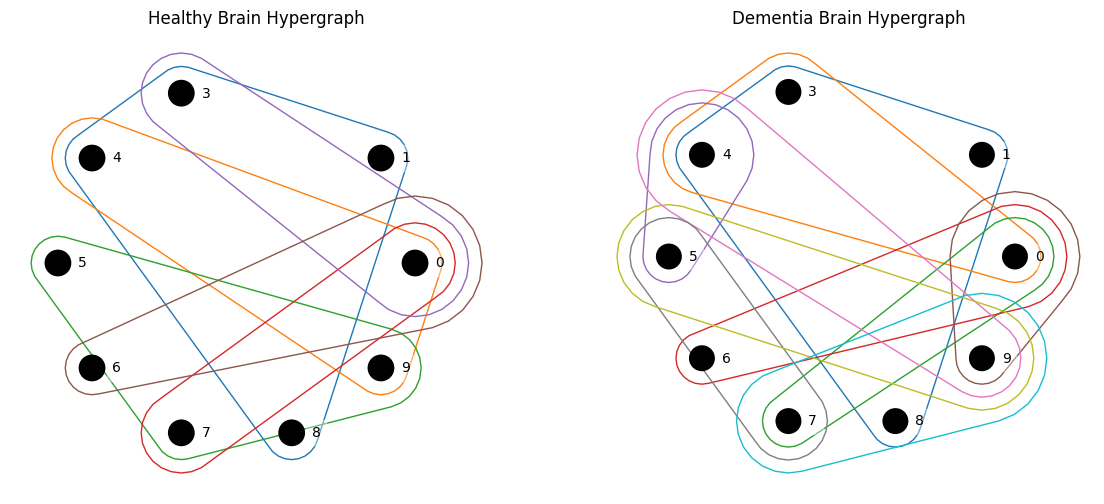

In [1191]:
def create_hypergraph(edges):
    """
    Convert list of hyperedges to HyperNetX format.
    Args:
        edges: List of edges

    Returns:
        HyperNetX Hypergraph object
    """
    edge_dict = {}
    for i, edge in enumerate(edges):
        edge_dict[i] = edge

    return hnx.Hypergraph(edge_dict)



healthy_hyperedges = detect_hyperedges(healthy_data, tau, epsilon, max_k, len(coordination_blocks))
healthy_hg = create_hypergraph(healthy_hyperedges)

dementia_hyperedges = detect_hyperedges(dementia_data, tau, epsilon, max_k, len(coordination_blocks))
dementia_hg = create_hypergraph(dementia_hyperedges)


# Visualize side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Use same layout for fair comparison
pos = nx.circular_layout(range(n_regions))

# Plot healthy hypergraph
hnx.draw(healthy_hg, ax=ax1, with_edge_labels=False, pos=pos, node_radius=3)
ax1.set_title("Healthy Brain Hypergraph")

# Plot dementia hypergraph
hnx.draw(dementia_hg, ax=ax2, with_edge_labels=False,  pos=pos, node_radius=3)
ax2.set_title("Dementia Brain Hypergraph")

plt.show()


We are almost ready to test the conjecture.

In [1192]:
def k_density(hypergraph, n_regions, k):
    """
    Compute order k density (fraction of possible k-edges that exist).

    Args:
        hypergraph: HyperNetX Hypergraph object
        k: Edge size to compute density for

    Returns:
        float: (number of k-edges) / C(n_vertices, k)
    """
    num_edges_k = len([e for e in hypergraph.edges if len(hypergraph.edges[e]) == k])
    max_possible_k = math.comb(n_regions, k)

    return num_edges_k / max_possible_k if max_possible_k > 0 else 0

def hypergraph_densities(hypergraph, n_regions, max_k=4):
    """
    Args:
        hypergraph: HyperNetX Hypergraph object

    Returns:
        dict: {k: order k density}
    """
    densities = {}
    for k in range(2, max_k + 1):
        densities[k] = k_density(hypergraph, n_regions, k)
    return densities


print("Coordination Blocks:\n", coordination_blocks)
print("Healthy graph:\n", healthy_edges)
print("Dementia graph:\n", dementia_edges)
print("Healthy hypergraph:\n", healthy_hyperedges)
print("Dementia hypergraph:\n", dementia_hyperedges)


print(f"\nGraph density comparison:")
healthy_density = nx.density(healthy_graph)
dementia_density = nx.density(dementia_graph)
print(f"  Healthy: {healthy_density:.3f}")
print(f"  Dementia: {dementia_density:.3f}")

# Compute hypergraph densities
healthy_densities = hypergraph_densities(healthy_hg, n_regions, max_k)
dementia_densities = hypergraph_densities(dementia_hg, n_regions, max_k)

# Print comparison
print("\nHypergraph density comparison")
print("=" * 40)
print("k  |  Healthy  |  Dementia |  Change")
print("-" * 40)

for k in range(2, max_k + 1):
    h_rho = healthy_densities[k]
    d_rho = dementia_densities[k]
    change = d_rho - h_rho
    direction = "↑" if change > 0 else "↓" if change < 0 else "="
    print(f"{k}  |  {h_rho:.5f}  |  {d_rho:.5f}   |  {change:+.5f} {direction}")

# Test conjecture
rho2_increases = dementia_densities[2] > healthy_densities[2]
rho3_decreases = dementia_densities[3] <= healthy_densities[3]
rho4_decreases = dementia_densities[4] <= healthy_densities[4]

print("\nConjecture Test:")
print(f"  ρ₂ increases: {rho2_increases}")
print(f"  ρ₃ decreases: {rho3_decreases}")
print(f"  ρ₄ decreases: {rho4_decreases}")


Coordination Blocks:
 [[0, 7], [3, 4], [0, 6], [0, 4, 9], [5, 7, 9], [1, 3, 4, 8]]
Healthy graph:
 [(0, 7), (3, 8), (0, 4), (3, 4), (4, 9), (0, 3), (0, 9), (1, 8), (5, 7), (0, 6), (7, 9), (1, 4), (4, 8), (5, 9), (1, 3)]
Dementia graph:
 [(0, 7), (3, 8), (0, 4), (3, 4), (4, 9), (0, 3), (0, 9), (1, 8), (5, 7), (0, 6), (7, 9), (1, 4), (4, 5), (4, 8), (5, 9), (1, 3)]
Healthy hypergraph:
 [(1, 3, 4, 8), (0, 4, 9), (5, 7, 9), (0, 7), (0, 3), (0, 6)]
Dementia hypergraph:
 [(1, 3, 4, 8), (0, 3, 4), (0, 7), (0, 6), (4, 5), (0, 9), (4, 9), (5, 7), (5, 9), (7, 9)]

Graph density comparison:
  Healthy: 0.333
  Dementia: 0.356

Hypergraph density comparison
k  |  Healthy  |  Dementia |  Change
----------------------------------------
2  |  0.06667  |  0.17778   |  +0.11111 ↑
3  |  0.01667  |  0.00833   |  -0.00833 ↓
4  |  0.00476  |  0.00476   |  +0.00000 =

Conjecture Test:
  ρ₂ increases: True
  ρ₃ decreases: True
  ρ₄ decreases: True


With a random seed, the above analysis shows that, on average, the conjecture is true. This provides some evidences for the hypergraph based analysis of brain functions.

Of course, the data is randomly generated and somewhat tailored to work with the algorithm. Nevertheless, it shows that the framework and algorithm has potential. Moreover, given real data, it should be possible to tailor the coordination detection algorithm to make it more effective at detecting real-brain coordination patterns, enabling the use of the hypergraph framework presented.